# Brief EDA on Spotify Jazz and Classical Artists' "Popularity" data.

We choose 50 artists and look at their tracks' popularity data via the Spotify API. In particular, we use the Gini coefficient to see how equally distributed the audience's concentration is among the artists' top tracks. We display results using some simple plots, and comment on what a longer investigation would aim for.


Imports and defaults.

In [ ]:

import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException


%matplotlib inline


plt.rcParams.update({"figure.dpi": 120})




Verify and authenticate.

In [ ]:

if not (os.environ.get("SPOTIPY_CLIENT_ID") and os.environ.get("SPOTIPY_CLIENT_SECRET")):
    raise RuntimeError(
        "Spotify credentials not found. "
        "Set SPOTIPY_CLIENT_ID and SPOTIPY_CLIENT_SECRET in your environment."
    )


auth_manager = SpotifyClientCredentials()
sp = spotipy.Spotify(auth_manager=auth_manager)

# just a test
try:
    test = sp.search(q="Nils Frahm", type="artist", limit=1)
    assert "artists" in test
except Exception as e:
    raise RuntimeError("Spotify API sanity check failed: " + str(e))


We choose 50 artists and very roughly map each to a genre. 

In [ ]:

ARTISTS = {
    # ~classical
    "Max Richter": "classical",
    "Ólafur Arnalds": "classical",
    "Nils Frahm": "classical",
    "Hania Rani": "classical",
    "Joep Beving": "classical",
    "Ludovico Einaudi": "classical",
    "Philip Glass": "classical",
    "Arvo Pärt": "classical",
    "John Adams": "classical",
    "Michael Nyman": "classical",
    "Caroline Shaw": "classical",
    "Bryce Dessner": "classical",
    "Hauschka": "classical",
    "Anna Thorvaldsdottir": "classical",
    "Alexandra Whittingham": "classical",
    "Sheku Kanneh-Mason": "classical",
    "Yunchan Lim": "classical",
    "Klaus Mäkelä": "classical",
    "Ashkenazy": "classical",
    "Solti": "classical",
    "Pavarotti": "classical",
    "Jonny Greenwood": "classical",
    "Fauré Ensemble": "classical",
    "Yuja Wang": "classical",
    "J.S. Bach": "classical",

    # ~jazz
    "Jacob Collier": "jazz",
    "Snarky Puppy": "jazz",
    "Kamasi Washington": "jazz",
    "Brad Mehldau": "jazz",
    "GoGo Penguin": "jazz",
    "Mammal Hands": "jazz",
    "Nubya Garcia": "jazz",
    "Esperanza Spalding": "jazz",
    "Robert Glasper": "jazz",
    "Vijay Iyer": "jazz",
    "Tigran Hamasyan": "jazz",
    "Christian Scott aTunde Adjuah": "jazz",
    "Ambrose Akinmusire": "jazz",
    "Cécile McLorin Salvant": "jazz",
    "Gregory Porter": "jazz",
    "Melody Gardot": "jazz",
    "José James": "jazz",
    "Laura Mvula": "jazz",
    "Jordan Rakei": "jazz",
    "Victor Ray": "jazz",
    "Tom Misch": "jazz",
    "The Teskey Brothers": "jazz",
    "Hiromi Uehara": "jazz",
    "Shai Maestro": "jazz",
    "Jeff Goldblum": "jazz"
}




Return the Spotify artist ID for a given artist name (first search hit) and return list of dicts with track_name, track_popularity, release_year for top 10 tracks.

In [ ]:
def get_artist_id(name):

    try:
        res = sp.search(q=name, type="artist", limit=1)
        items = res["artists"]["items"]
        if not items:
            return None
        return items[0]["id"]
    except SpotifyException as e:
        raise

def get_top_tracks(artist_id, market="GB"):
   
    try:
        tracks = sp.artist_top_tracks(artist_id, country=market)["tracks"]
    except SpotifyException:
        time.sleep(1)
        tracks = sp.artist_top_tracks(artist_id, country=market)["tracks"]

    results = []
    for t in tracks[:10]:
        name = t.get("name")
        pop = t.get("popularity", 0)
        release = t["album"].get("release_date", "")
        year = int(release[:4]) if release else None
        results.append({
            "track_name": name,
            "track_popularity": pop,
            "release_year": year
        })
    return results



Collect track data.

In [ ]:
rows = []
errors = []

for artist, genre in ARTISTS.items():
    try:
        aid = get_artist_id(artist)
        if not aid:
            errors.append((artist, "no id"))
            continue
        tracks = get_top_tracks(aid)
        if not tracks:
            errors.append((artist, "no tracks"))
            continue
        for t in tracks:
            rows.append({
                "artist": artist,
                "genre_group": genre,
                "track_name": t["track_name"],
                "track_popularity": t["track_popularity"],
                "release_year": t["release_year"]
            })
        time.sleep(0.2)
    except Exception as e:
        errors.append((artist, str(e)))

df = pd.DataFrame(rows)
print("Rows collected:", df.shape[0])
if errors:
    print("Some artists had issues:", errors)


os.makedirs("../data", exist_ok=True)
df.to_csv("../data/artist_tracks.csv", index=False)



Rows collected: 489


We define a function to calculate Gini coeff.

In [ ]:
def gini(values):
   
    array = np.array(values, dtype=float)
    if array.size == 0:
        return np.nan
    if np.any(array < 0):
        raise ValueError("Gini requires non-negative values")
    total = array.sum()
    n = array.size
    if n == 1 or total == 0:
        return 0.0
    array = np.sort(array)
    index = np.arange(1, n + 1)
    return (2.0 * np.sum(index * array)) / (n * total) - (n + 1) / n



We calculate the Gini coefficient for each artist in our list and sort by genre and popularity.

In [ ]:
metrics_df = (
    df.groupby(["artist", "genre_group"], sort=False)
      .apply(lambda x: pd.Series({
          "popularity_gini": gini(x["track_popularity"].values),
          "n_tracks": x.shape[0],
          "mean_popularity": x["track_popularity"].mean()
      }))
      .reset_index()
)

metrics_sorted = metrics_df.sort_values(["genre_group", "popularity_gini"], ascending=[True, True]).reset_index(drop=True)
metrics_sorted




/var/folders/8k/dmjymq8j3kd_5p0th9tbpjy00000gn/T/ipykernel_49892/3864330917.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: pd.Series({


,artist,genre_group,popularity_gini,n_tracks,mean_popularity
0,Nils Frahm,classical,0.026606,10.0,54.500000
1,Max Richter,classical,0.029296,10.0,61.100000
2,Ólafur Arnalds,classical,0.030017,10.0,58.300000
3,Hania Rani,classical,0.036000,10.0,52.500000
4,Ashkenazy,classical,0.036602,10.0,57.100000
5,Joep Beving,classical,0.045355,10.0,54.900000
6,Yunchan Lim,classical,0.052062,10.0,38.800000
7,Ludovico Einaudi,classical,0.053959,10.0,68.200000
8,Sheku Kanneh-Mason,classical,0.057505,10.0,51.300000
9,Jonny Greenwood,classical,0.059300,10.0,45.700000


We plot a simple bar chart.

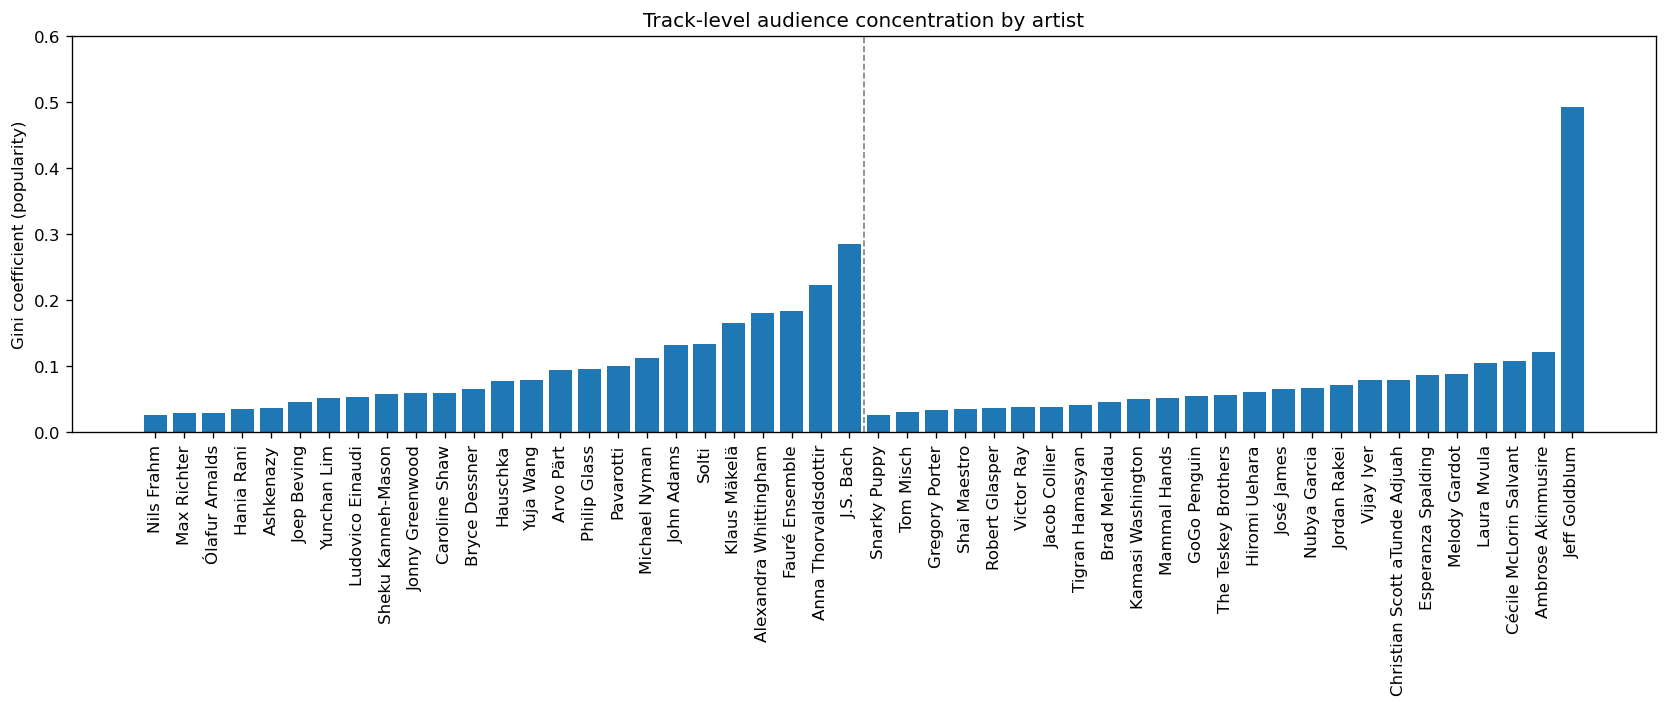

In [ ]:
plt.figure(figsize=(14,6))
artists = metrics_sorted["artist"].tolist()
gini_vals = metrics_sorted["popularity_gini"].tolist()
plt.bar(artists, gini_vals)


cut = (metrics_sorted["genre_group"] == "classical").sum()
if cut > 0 and cut < len(artists):
    plt.axvline(cut - 0.5, linestyle="--", color="gray", linewidth=1)

plt.xticks(rotation=90)
plt.ylabel("Gini coefficient (popularity)")
plt.title("Track-level audience concentration by artist")
plt.ylim(0,0.6)
plt.tight_layout()
plt.show()


We generate a table of basic data features.

In [ ]:
metrics_sorted.groupby("genre_group")["popularity_gini"].describe()


,count,mean,std,min,25%,50%,75%,max
genre_group,,,,,,,,
classical,25.0,0.096777,0.067002,0.026606,0.052062,0.077241,0.133051,0.285714
jazz,25.0,0.078812,0.090021,0.025893,0.039245,0.056794,0.079538,0.492754


We visualise using a box plot.

<Figure size 960x720 with 0 Axes>

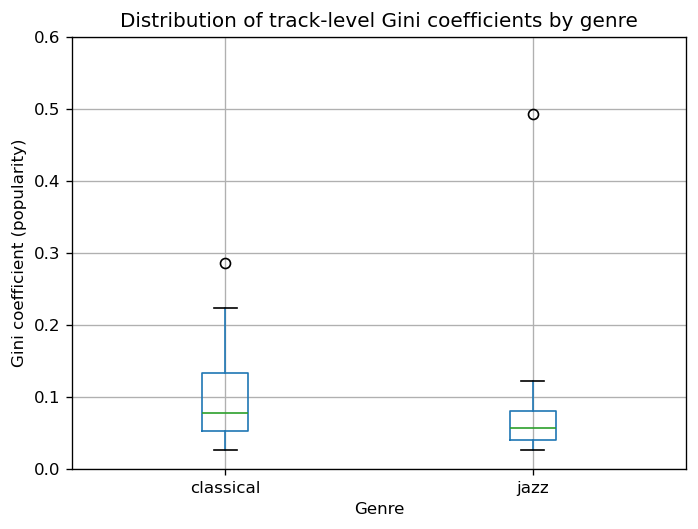

In [ ]:
plt.figure(figsize=(8,6))
metrics_sorted.boxplot(column="popularity_gini", by="genre_group")
plt.title("Distribution of track-level Gini coefficients by genre")
plt.suptitle("")
plt.ylabel("Gini coefficient (popularity)")
plt.xlabel("Genre")
plt.ylim(0,0.6)
plt.show()


In [ ]:
metrics_sorted.to_csv("../data/artist_gini_metrics.csv", index=False)


